## Winner Take All Convolutional Autoencoders
Let's walk through training and investigating a winner take all convolutional autoencoder on the MNIST dataset. We'll start by importing the necessary libraries and loading the dataset. We'll visualize training in TensorBoard.

In [1]:
import torch
import numpy as np
from datetime import datetime
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from tools.dataset import split_dataset
import random

Define constants.

In [2]:
RANDOM_SEED = 42
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128

Make sure the current device is logged.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Torch running on {device}")

Torch running on cuda


### Import and prepare MNIST dataset
We will work with the MNIST dataset for experimenation and setup. Let's download it using the handy `torchvision.MNIST` datasets. We will first prepare our train and validation splits.

In [15]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
dataset = datasets.MNIST(
    root="~/.pytorch/MNIST_data/", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="~/.pytorch/MNIST_data/", train=False, download=True, transform=transform
)

### Prepare dataloaders
The dataloaders will be helpful to let us access the dataset in batches during training.

In [17]:
# Define dataloaders
train_loader, validation_loader = split_dataset(
    dataset,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    random_seed=RANDOM_SEED,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

Visualize the data

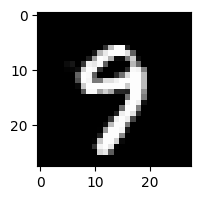

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
images, labels = next(iter(train_loader))
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (2,2)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

Import implemented models and training loop.

In [8]:
from torch import nn
from tools.train import train_for_n_epochs

## Train autoencoders
Let's train the autoencoder and visualize the training in TensorBoard. We will train the autoencoder for 10 epochs. The goal of this excercise is to make sure the autoencoder is learning something useful. We will not be using the autoencoder for any downstream tasks.

Import the model from our models repository

In [9]:
from models.convautoencoders import (
    ConvAutoencoder,
    WTASpatialConvAutoencoder,
    WTALifetimeSparseConvAutoencoder,
    WTASpatialLifetimeSparseConvAutoencoder,
)


Let's define some constants.

In [10]:
N_EPOCHS = 10
VISUALIZE_EVERY = 1
LEARNING_RATE = 1e-3

Let's define the optimizer and loss criterion we will use.

In [13]:
criterion = nn.MSELoss()

### Train Winner Takes All Convolutional Autoencoder with Spatial Sparsity
Let's train our Autoencoder architecture with a basic training loop to verify outputs and such.

Import the model from our models repository

In [ ]:
wta_model = WTASpatialConvAutoencoder()
wta_model.to(device)
print(f"Model architecture:\n\n{wta_model}")
optimizer = torch.optim.Adam(wta_model.parameters(), lr=LEARNING_RATE)

Train model for `N_EPOCHS`:

In [ ]:
writer = SummaryWriter(
    f"logs/{wta_model.name}_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
)
train_for_n_epochs(
    N_EPOCHS,
    VISUALIZE_EVERY,
    wta_model,
    train_loader,
    validation_loader,
    optimizer,
    criterion,
    device,
    checkpoint_dir="models"
)

### Train Winner Takes All Convolutional Autoencoder with Lifetime Sparsity
Let's train our Autoencoder architecture with a basic training loop to verify outputs and such.

Import the model from our models repository

In [ ]:
wta_lifetime_model = WTALifetimeSparseConvAutoencoder(k_percentage=0.9)
wta_lifetime_model.to(device)
print(f"Model architecture:\n\n{wta_lifetime_model}")
optimizer = torch.optim.Adam(wta_lifetime_model.parameters(), lr=LEARNING_RATE)

Set up basic training hyper parameters and TensorBoard training visualizer

Train model for `N_EPOCHS`.

In [ ]:
writer = SummaryWriter(
    f"logs/{wta_lifetime_model.name}_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
)
train_for_n_epochs(
    N_EPOCHS,
    VISUALIZE_EVERY,
    wta_lifetime_model,
    train_loader,
    validation_loader,
    optimizer,
    criterion,
    device,
)

## Train Winner Takes All Convolutional Autoencoder with Spatial Sparsity and Lifetime Sparsity
Let's train our Autoencoder architecture with a basic training loop to verify outputs and such.

In [ ]:
K_PERCENTAGE = 0.05

In [ ]:
# Initialize model
wta_spatial_lifetime_model = WTASpatialLifetimeSparseConvAutoencoder(
    k_percentage=K_PERCENTAGE
)
wta_spatial_lifetime_model.to(device)
print(f"Model architecture:\n\n{wta_spatial_lifetime_model}")
optimizer = torch.optim.Adam(wta_spatial_lifetime_model.parameters(), lr=LEARNING_RATE)

Train model for `N_EPOCHS`.

In [ ]:
# Setup summary writer and set training going
writer = SummaryWriter(
    f"logs/{wta_spatial_lifetime_model.name}_{K_PERCENTAGE}_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
)
train_for_n_epochs(
    N_EPOCHS,
    VISUALIZE_EVERY,
    wta_spatial_lifetime_model,
    train_loader,
    validation_loader,
    optimizer,
    criterion,
    device,
    writer,
)

Experiment with multiple percentages from `0.1` to `1`:

In [ ]:
K_PERCENTAGES = np.linspace(0.1, 1, 10)
for K_PERCENTAGE in K_PERCENTAGES:
    print(f"Training WTA Autoencoder with lifetime sparsity k% {K_PERCENTAGE}.")
    # Initialize model
    wta_spatial_lifetime_model = WTASpatialLifetimeSparseConvAutoencoder(
        k_percentage=K_PERCENTAGE
    )
    wta_spatial_lifetime_model.to(device)
    # Setup summary writer and set training going
    writer = SummaryWriter(
        f"logs/{wta_spatial_lifetime_model.name}_{K_PERCENTAGE}_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    )
    train_for_n_epochs(
        N_EPOCHS,
        VISUALIZE_EVERY,
        wta_spatial_lifetime_model,
        train_loader,
        validation_loader,
        optimizer,
        criterion,
        device,
        writer,
    )

## Visualizing learned filters from WTA Convolutional Autoencoder
Let's visualize the learned filters from the convolutional layers of the autoencoder. We will visualize the filters from the first convolutional layer of the autoencoder.

In [ ]:
PATH_TO_CHECKPOINTS = "models"

In [ ]:
wta_conv_autoencoder = WTASpatialLifetimeSparseConvAutoencoder()
wta_conv_autoencoder.load_state_dict(torch.load(PATH_TO_CHECKPOINTS))

In [ ]:
# Visualize learned filters
fig = plt.figure(figsize=(20, 20))
for i, filter in enumerate(wta_conv_autoencoder.encoder[0].weight):
    ax = fig.add_subplot(8, 8, i + 1)
    ax.imshow(filter.detach().cpu().squeeze(), cmap="gray")
    ax.axis("off")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect("equal")